# Report
## Project 3: Collaboration and Competition
### Udacity Deep Reinforcement Learning Nanodegree
by Kitson Swann
2021-05-14

## Tennis Environment

![playing.gif](playing.gif)

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

### States

The state space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. 

### Actions

Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

# Rewards

The task is episodic. The task is considered solved when the maximum of the total score for the two agents is +0.5 (over 100 consecutive episodes).

After each episode, we add up the rewards that each agent received (without discounting, to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
This yields a single score for each episode.
The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

## Tennis Environment

Below you can see the environment initialized with the state and action spaces shown.

In [1]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
#from optimize import find_optimal_hyperparameters
from train import train_ddpg

RANDOM_SEED = 2

%matplotlib inline

env = UnityEnvironment(file_name='./env/Tennis.app', seed=RANDOM_SEED, no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.29742813 -1.5
 -0.          0.          7.17024279  6.         -0.          0.        ]


In [ ]:
env.close()

## Solution

### Algorithm

I used the Deep Deterministic Policy Gradient agent I had previously developed for Project 2, which was originally based on the Pendulum environment example [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum). I modified the training loop to work with the Unity Tennis environment, which required some minor changes from the Project 2 version. In particular the calculation of the rewards is different, and requires taking the episode max over two competing agents.

The Deep Deterministic Policy Gradient (DDPG) algorithm is similar to a Deep Q Network (DQN) but adapted and modified to suit the task of solving environments with continuous action spaces.

The DDPG algorithm is similar to a DQN in that:
- It uses a replay buffer to store experience tuples which it samples mini-batches from to perform gradient descent steps on the network. 
- It also makes use of local and a target networks to make target values more stationary while training.

However, DQN estimates a Q function that outputs a value for each possible discrete action. Then the agent greedily chooses the action with the highest value. The DDPG instead includes:
- an actor - which is a deterministic policy network that takes in a state and returns an action to take directly and,
- a critic - a value network which takes in the state plus the action from the actor, and returns the value of the state/action pair

In the learning step in DDPG:

- A minibatch is sampled from the replay buffer
- The target actor network predicts the next actions from the states
- The target critic predicts the values of the chosen actions
- The Q targets are calculated
- The Q expected values are calculated using the local critic
- The critic loss is calculated between the expected and target Q values
- The loss is minimized on the local critic network
- The local actor network predicts the next actions
- The actor loss is calculated using the local critic
- The loss is minimized on the local actor network
- The actor and critic target networks are soft updated with the local network parameters

### Initial Experimentation

I started with the hyperparameters I had used for Project 2. The Tennis episodes are not static in length like that of the Reacher environment, since the episode continues as long as the ball is in the air. In the early stages the episodes end quickly and they get longer in duration as the agents progress in skill and can keep the ball in the air. I initially ran a training run of 2000 episodes, and saw promising progress on scores, so I increased the training to 20,000 episodes. To my suprise, the agent solved the task in 4215 episodes.

I am not totally suprised by this result, as hyper-parameter choices in Deep Learning often end up being good rules of thumb, and work across many similar tasks. This is one the principles they teach in the Fast.ai course for getting good results in training deep neural networks.

In [2]:
optimal_params = {
  "random_seed": RANDOM_SEED,
  "noise_sigma": 0.02,
  "noise_theta": 0.015,
  "weight_decay": 0,
  "tau": 0.05,
  "gamma": 0.95,
  "critic_lr": 0.0001,
  "actor_lr": 0.001,
  "critic_fc2_units": 128,
  "critic_fc1_units": 128,
  "actor_fc2_units": 128,
  "actor_fc1_units": 128,
  "update_times": 10,
  "update_every": 20,
  "batch_size": 256,
  "buffer_size": 1000000.0,
  "eps_decay": 0.7,
  "eps_end": 0.3,
  "eps_start": 1.0,
  "action_size": action_size,
  "state_size": state_size,
  "n_episodes": 20000,
  "solved_threshold": 0.5,
  "break_early": True,
  "name": "_base",
  "num_agents": 2,
  "brain_name": brain_name
}

scores = train_ddpg(env=env, **optimal_params)

{
  "random_seed": 2,
  "noise_sigma": 0.02,
  "noise_theta": 0.015,
  "weight_decay": 0,
  "tau": 0.05,
  "gamma": 0.95,
  "critic_lr": 0.0001,
  "actor_lr": 0.001,
  "critic_fc2_units": 128,
  "critic_fc1_units": 128,
  "actor_fc2_units": 128,
  "actor_fc1_units": 128,
  "update_times": 10,
  "update_every": 20,
  "batch_size": 256,
  "buffer_size": 1000000.0,
  "eps_decay": 0.7,
  "eps_end": 0.3,
  "eps_start": 1.0,
  "action_size": 2,
  "state_size": 24,
  "n_episodes": 20000,
  "solved_threshold": 0.5,
  "break_early": true,
  "name": "_base",
  "num_agents": 2,
  "brain_name": "TennisBrain"
Replay Buffer Size: 1000000.0, Batch Size: 256
Episode 9	Average Score: 0.0	Score: 0.0

/Users/kitson_swann/Documents/udacity_drl/udacity_drl_p3/agent.py:166: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 200	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 300	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 400	Average Score: 0.0546	Max Score: 0.1	Min Score: 0.1
Episode 500	Average Score: 0.0653	Max Score: 0.1	Min Score: 0.1
Episode 600	Average Score: 0.0764	Max Score: 0.0	Min Score: 0.0
Episode 700	Average Score: 0.0646	Max Score: 0.09	Min Score: 0.09
Episode 800	Average Score: 0.0645	Max Score: 0.1	Min Score: 0.1
Episode 900	Average Score: 0.079	Max Score: 0.1	Min Score: 0.1
Episode 1000	Average Score: 0.0811	Max Score: 0.1	Min Score: 0.1
Episode 1100	Average Score: 0.0837	Max Score: 0.1	Min Score: 0.1
Episode 1200	Average Score: 0.0844	Max Score: 0.0	Min Score: 0.0
Episode 1300	Average Score: 0.0851	Max Score: 0.1	Min Score: 0.1
Episode 1400	Average Score: 0.0888	Max Score: 0.09	Min Score: 0.09
Episode 1500	Average Score: 0.0855	Max Score: 0.0	Min Score: 0.0
Episode 1600	Average Score: 0.0868	Max S

In [3]:
import json

with open("scores.json", "w") as f:
    json.dump({"scores": scores}, f, indent=2)

### Plot of Average Scores Over 1000 Episodes

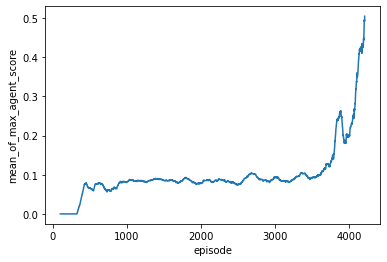

In [4]:
import seaborn as sns
import pandas as pd

with open("scores.json", "r") as f:
    scores = json.load(f)

sdf = pd.DataFrame(scores)
sdf = sdf.reset_index().rename(columns={"index": "episode", "scores": "max_agent_score"})
sdf["mean_of_max_agent_score"] = sdf["max_agent_score"].rolling(window=100).mean()

sns.lineplot(data=sdf, x="episode", y="mean_of_max_agent_score")

## Watch The Trained Agent

Below I've loaded the trained agent and shown a gif of it performing the task.

In [ ]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name='./env/Tennis.app')

RANDOM_SEED=2
NUM_AGENTS=2

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
from agent import Agent
import torch
import numpy as np

params = {
  "random_seed": RANDOM_SEED,
  "noise_sigma": 0.02,
  "noise_theta": 0.015,
  "weight_decay": 0,
  "tau": 0.05,
  "gamma": 0.95,
  "critic_lr": 0.0001,
  "actor_lr": 0.001,
  "critic_fc2_units": 128,
  "critic_fc1_units": 128,
  "actor_fc2_units": 128,
  "actor_fc1_units": 128,
  "update_times": 10,
  "update_every": 20,
  "batch_size": 256,
  "buffer_size": 1000000.0,
  "eps_decay": 0.7,
  "eps_end": 0.3,
  "eps_start": 1.0,
  "action_size": 2,
  "state_size": 24,
}

agent = Agent(**params)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor_base.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_base.pth'))
        
env_info = env.reset(train_mode=False)[brain_name]
max_scores = []

for i_episode in range(10):
    agent.reset()
    states = env_info.vector_observations
    agent_scores = np.zeros(NUM_AGENTS)
    i = 1
    while True:
        actions = agent.act(state=states, add_noise=False)
        actions = np.clip(actions, -1, 1)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        states = next_states
        agent_scores += rewards
        print(f"\rTimestep: {i}\tAgent 1 Reward: {round(rewards[0],4)}\tAgent 2 Reward: {round(rewards[1],4)}", end = "")
        if np.any(dones):
            break
        i += 1
    
    episode_max = np.max(agent_scores)
    print(f"\rEpisode: {i_episode}\tMax Reward: {round(episode_max,4)}\tAgent 1 Total Reward: {round(agent_scores[0],4)}\tAgent 2 Total Reward: {round(agent_scores[1],4)}")

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Replay Buffer Size: 1000000.0, Batch Size: 256
Episode: 0	Max Reward: 0.19	Agent 1 Total Reward: 0.1	Agent 2 Total Reward: 0.19
Episode: 1	Max Reward: 2.6	Agent 1 Total Reward: 2.6	Agent 2 Total Reward: 2.6
Timestep: 24	Agent 1 Reward: 0.0	Agent 2 Reward: 0.0

![playing.gif](playing.gif)

## Training Run with Larger Hidden Layers

In the above training session the agent solves the environment, but the play didn't look very natural. There is a lot of back and fourth movement that seems uneccessary that a human agent wouldn't do. I was curious to see if a larger network would change this. The larger network took much longer to get to a point where the agents were able to rally, and it came close to achieving the 0.5 threshold but then appeared to get worse over time, so I terminated it early.

In [ ]:
alternate_params = {
  "random_seed": RANDOM_SEED,
  "noise_sigma": 0.02,
  "noise_theta": 0.015,
  "weight_decay": 0,
  "tau": 0.05,
  "gamma": 0.95,
  "critic_lr": 0.0001,
  "actor_lr": 0.001,
  "critic_fc2_units": 300,
  "critic_fc1_units": 400,
  "actor_fc2_units": 300,
  "actor_fc1_units": 400,
  "update_times": 10,
  "update_every": 20,
  "batch_size": 256,
  "buffer_size": 1000000.0,
  "eps_decay": 0.7,
  "eps_end": 0.3,
  "eps_start": 1.0,
  "action_size": action_size,
  "state_size": state_size,
  "n_episodes": 20000,
  "solved_threshold": 0.5,
  "break_early": True,
  "name": "_large",
  "num_agents": 2,
  "brain_name": brain_name
}

scores = train_ddpg(env=env, **alternate_params)

{
  "random_seed": 2,
  "noise_sigma": 0.02,
  "noise_theta": 0.015,
  "weight_decay": 0,
  "tau": 0.05,
  "gamma": 0.95,
  "critic_lr": 0.0001,
  "actor_lr": 0.001,
  "critic_fc2_units": 300,
  "critic_fc1_units": 400,
  "actor_fc2_units": 300,
  "actor_fc1_units": 400,
  "update_times": 10,
  "update_every": 20,
  "batch_size": 256,
  "buffer_size": 1000000.0,
  "eps_decay": 0.7,
  "eps_end": 0.3,
  "eps_start": 1.0,
  "action_size": 2,
  "state_size": 24,
  "n_episodes": 20000,
  "solved_threshold": 0.5,
  "break_early": true,
  "name": "_large",
  "num_agents": 2,
  "brain_name": "TennisBrain"
Replay Buffer Size: 1000000.0, Batch Size: 256
Episode 9	Average Score: 0.0	Score: 0.0

/Users/kitson_swann/Documents/udacity_drl/udacity_drl_p3/agent.py:166: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 200	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 300	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 400	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 500	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 600	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 700	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 800	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 900	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 1000	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 1100	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 1200	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 1300	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 1400	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 1500	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 1600	Average Score: 0.0	Max Score: 0.0	Min Score: 0.0
Episode 1700	Aver

# Ideas for Future Work

I did not do an extensive hyperparameter search here because I had already solved the environent, and because the agent didn't show any positive scores until 400 episodes into training. So, to get any signal from the hyperparameter optimization I would probably have to train each parameter set for a minimum of 400 episodes, which would take a prohibitively long time. If I had more time and access to a GPU I could conduct a more exhaustive hyper-parameter search.

In the previous project instructions, there were also number of other algorithms mentioned that may work better including:

- Trust Region Policy Optimization (TRPO)
- Truncated Natural Policy Gradient (TNPG)
- Proximal Policy Optimization (PPO)
- Distributed Distributional Deterministic Policy Gradients (D4PG)

The next steps for me would be to investigate and attempt to solve the task with one or more of these alternate algorithms.